# 6.基因聚类与KEGG

In [1]:
import sys
sys.path = ["../../.."] + sys.path # 切换到项目目录下

import scvelo as scv
import velovgi

Global seed set to 0
/home/huang/.conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/huang/.conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## 1. 数据读入

In [2]:
subsample_adata = scv.read("./data/subsample_adata.h5ad") # 额外读取
adata = velovgi.tl.read_adata("./data/adata/")

batch_key = "stage"
cluster_key = "celltype"
pseudotime_key = "velocity_pseudotime"
subsample_adata, adata

load ./data/adata//adata.h5ad
load ./data/adata//sample_recover.pkl


(AnnData object with n_obs × n_vars = 4907 × 2000
     obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
     var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling'
     uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'neighbors'
     obsm: 'X_pca', 'X_umap'
     layers: 'Ms', 'Mu', 'fit_t', 'latent_time_velovgi', 'spliced', 'unspliced', 'velocity', 'velocity_u'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 9815 × 2000
     obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
     var: 'Acces

## 2. 基因聚类

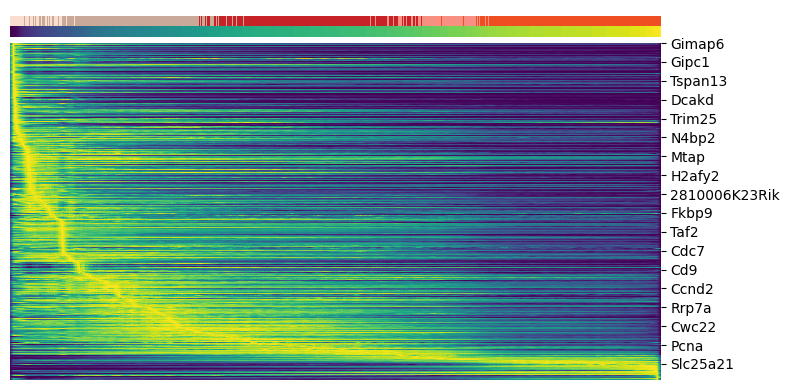

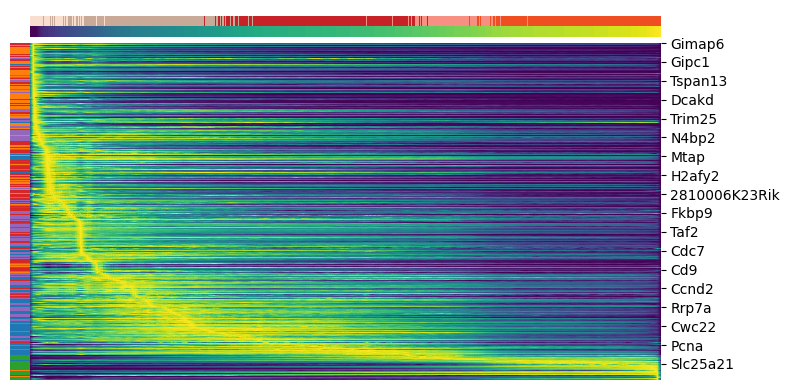

In [3]:
# 使用转换后的结果进行基因聚类
import seaborn as sns
from sklearn.cluster import KMeans

# 基因分类
k = 5

top_genes = list(adata.var.index[:2000])
cm = scv.pl.heatmap(adata, var_names=top_genes, sortby="velocity_pseudotime", sort=True, col_color=[cluster_key, "velocity_pseudotime"], n_convolve=100, show=False) # 保存平滑之后的结果
A = cm.data2d # 这里提取出clustermap的
classifier = KMeans(n_clusters=k, random_state=0).fit(A)
gene_cluster_list = classifier.labels_

# # 手动设置
# sep = int(len(top_genes)/k)
# for i in range(k):
#     gene_cluster_list[i*sep: (i+1)*sep] = i

# 颜色转换
color_dict = dict(enumerate(sns.palettes.color_palette()[:k]))
color_list = list(map(lambda x: color_dict[x], gene_cluster_list))

scv.pl.heatmap(adata, var_names=top_genes, sortby="velocity_pseudotime", col_color=[cluster_key, "velocity_pseudotime"], n_convolve=100, row_colors = color_list)

## 3. 基因聚类的平均值变化情况

([], [])

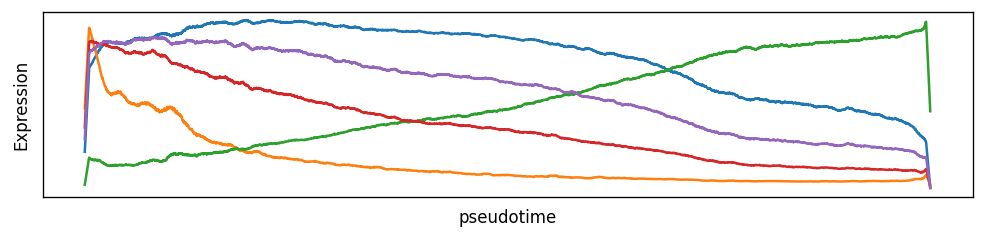

In [4]:
import matplotlib.pyplot as plt

A["gene_cluster"] = gene_cluster_list # 添加最后一列
mean_df = A.groupby("gene_cluster").mean().iloc[:, :-1].T # 去除最后一列

plt.figure(figsize=(10, 2), dpi=120)

for i in range(k):
    plt.plot(mean_df[i], color=color_dict[i])

plt.xlabel("pseudotime")
plt.xticks([])
plt.ylabel("Expression")
plt.yticks([])

## 4. KEGG富集成表格

In [5]:
import gseapy as gp


# 抽取各个聚类的基因名列表
gene_list_dict = {}
for i in range(k):
    gene_list = list(adata.var.index[gene_cluster_list==i])
    gene_list_dict[i] = gene_list

# 对各个聚类执行富集
kegg_df_dict = {}
for i in gene_list_dict.keys():
    print(i)
    kegg_df = gp.enrichr(gene_list_dict[i], gene_sets="KEGG_2019_Mouse").res2d
    kegg_df_dict[i] = kegg_df

kegg_df_dict[0]

0
1
2
3
4


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2019_Mouse,Pathways in cancer,30/535,0.000003,0.000739,0,0,2.760927,3.506302e+01,ITGB1;SPI1;HSP90AB1;CTBP2;LRP5;LPAR1;BRCA2;ETS...
1,KEGG_2019_Mouse,p53 signaling pathway,9/71,0.000025,0.002240,0,0,6.566949,6.964832e+01,CCND3;CCND2;CDK6;CCNE1;CASP3;SESN1;SIAH1A;ATM;BID
2,KEGG_2019_Mouse,Adherens junction,9/72,0.000028,0.002240,0,0,6.462380,6.780157e+01,TCF7L1;YES1;PARD3;PTPN6;WASL;ACTN4;NECTIN2;IGF...
3,KEGG_2019_Mouse,Leukocyte transendothelial migration,11/115,0.000047,0.002849,0,0,4.796844,4.779301e+01,VASP;ITGB1;CDH5;NCF4;CYBA;ACTN4;THY1;ARHGAP35;...
4,KEGG_2019_Mouse,Cell cycle,11/123,0.000087,0.004174,0,0,4.452381,4.161861e+01,CDKN1C;CCND3;CCND2;ORC6;CDK6;TFDP1;CCNE1;ATM;B...
...,...,...,...,...,...,...,...,...,...,...
237,KEGG_2019_Mouse,Herpes simplex virus 1 infection,6/433,0.917411,0.932830,0,0,0.619465,5.339741e-02,BST2;CASP3;EIF4EBP1;CALR;BID;ZFP266
238,KEGG_2019_Mouse,Neurotrophin signaling pathway,1/121,0.932787,0.944496,0,0,0.369021,2.567572e-02,CALM3
239,KEGG_2019_Mouse,Cytokine-cytokine receptor interaction,2/292,0.988965,0.997207,0,0,0.303417,3.366691e-03,BMP2;MPL
240,KEGG_2019_Mouse,Neuroactive ligand-receptor interaction,2/348,0.996359,0.999996,0,0,0.253570,9.248916e-04,PARD3;LPAR1


In [6]:
# 看看此处富集的通路与CellDancer中哪些出现了
pathway_list = [
    "Angiogenesis",
    "Vasculogenesis",
    "Wound healing",
    "Actin cytoskeleton organization",
    "Cell division",
    "Cell cycle",
    "Chromatin organization",
    "RNA splicing",
    "Translation",
    "Carboxylic acid metabolic process",
    "Erythrocyte development",
    "Heme biosynthetic process",
    "Oxygen transport",
    "Cellular oxidant detoxification"
]
for i in kegg_df_dict.keys():
    print(i)
    kegg_df = kegg_df_dict[i]
    for term in kegg_df["Term"]:
        if term in pathway_list:
            print(term)
# 出现的并不多，那暂时自己找几个吧

0
Cell cycle
1
Cell cycle
2
Cell cycle
3
Cell cycle
4
Cell cycle


In [7]:
for i in kegg_df_dict.keys():
    print(kegg_df_dict[i].head()["Term"])

0                      Pathways in cancer
1                   p53 signaling pathway
2                       Adherens junction
3    Leukocyte transendothelial migration
4                              Cell cycle
Name: Term, dtype: object
0    Transcriptional misregulation in cancer
1                      p53 signaling pathway
2                              RNA transport
3                                 Cell cycle
4                                Hepatitis B
Name: Term, dtype: object
0    Protein processing in endoplasmic reticulum
1                         Glutathione metabolism
2                              Purine metabolism
3                      Pentose phosphate pathway
4        Progesterone-mediated oocyte maturation
Name: Term, dtype: object
0          Pathways in cancer
1    Chronic myeloid leukemia
2         Cellular senescence
3                  Cell cycle
4    Hepatocellular carcinoma
Name: Term, dtype: object
0                                 Focal adhesion
1    Protein proc

,RNA transport,Cell cycle,Ribosome,Homologous recombination,Ribosome
0,0.262610,0.004174,0.175176,0.254385,0.175176
1,0.183898,0.289960,0.839832,1.000000,0.839832
2,0.646105,0.644829,0.715320,1.000000,0.715320
3,0.327382,0.007306,0.341452,1.000000,0.341452
4,0.482869,0.000020,0.493823,0.589628,0.493823


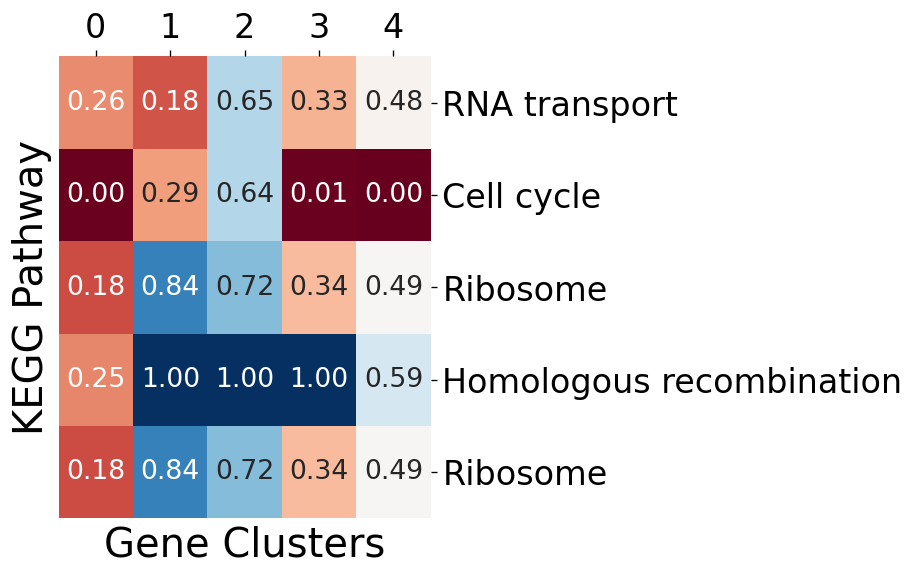

In [8]:
import numpy as np
import pandas as pd

plt.figure(figsize=(4,5), dpi=120)
pathway_list = [
    "RNA transport",
    "Cell cycle",
    "Ribosome",
    "Homologous recombination",
    "Ribosome",
]

df = pd.DataFrame(np.ones((k, len(pathway_list))), columns=pathway_list)

for i in kegg_df_dict.keys():
    kegg_df = kegg_df_dict[i]
    for pathway in pathway_list:
        if pathway in list(kegg_df["Term"]):
            pvalue = float(kegg_df[kegg_df["Term"] == pathway]["Adjusted P-value"])
            df.loc[i,pathway] = pvalue # 有该通路则更新值

# 表格还需要美化
ax = sns.heatmap(df.T, annot=True, fmt=".2f", cbar=False, cmap="RdBu", annot_kws={"fontsize":16}, )

ax.xaxis.set_ticks_position("top") 
ax.yaxis.set_ticks_position("right") 
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)

plt.xlabel("Gene Clusters", fontsize=24)
plt.ylabel("KEGG Pathway", fontsize=24)
df

## 5. 色带绘制

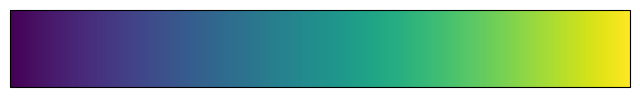

In [9]:
import matplotlib as mpl

# 基因表达随时间变化色带
fig, ax = plt.subplots(1, 1, figsize=(8, 1))
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0, vmax=1)
im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

# 干脆文字部分都不要了
cbar = fig.colorbar(
    im, cax=ax, orientation="horizontal",
    ticks=[],
)

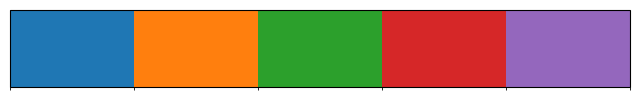

In [10]:
# 基因聚类色带
colors = color_dict.values()
fig, ax = plt.subplots(figsize=(8, 1))
cmap = mpl.colors.ListedColormap(colors) # 指定离散颜色
bounds = range(len(colors)+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

fig.colorbar(
    im, cax=ax, orientation="horizontal",
    ticks=[]
)

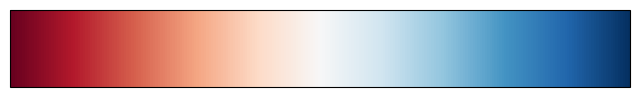

In [11]:
# 显著性色带
fig, ax = plt.subplots(1, 1, figsize=(8, 1))
cmap = mpl.cm.RdBu
norm = mpl.colors.Normalize(vmin=0, vmax=1)
im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

cbar = fig.colorbar(
    im, cax=ax, orientation="horizontal",
    ticks=[],
)